# Pyroによるベイズ線形回帰
---

データセット $D = \{(x_n, y_n)\}_{n=1}^N$ に対してモデル $y = wx + b + \epsilon, \; \epsilon \sim \mathcal N(\epsilon; 0, \beta^{-1})$ を当てはめる問題をベイズ推論で解く．

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

データセット$D = \{(x_n, y_n)\}_{n=1}^N$を生成する．

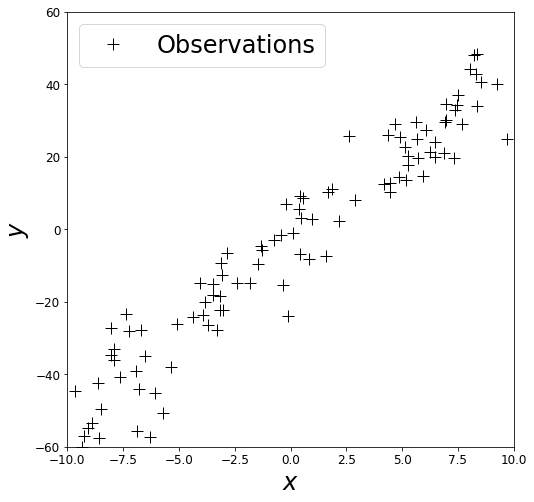

In [2]:
N = 100
x_data = np.random.uniform(-10., 10., N)
eps = np.random.normal(0., 8.0, N)
y_data = 5 * x_data - 4 + eps

x = np.linspace(-10., 10.)

plt.rcParams['font.size'] = 24
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

fig_data = plt.figure(figsize=(8, 8))

plt.plot(x_data, y_data, 'k+', label='Observations', markersize=12);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.xlim(-10., 10.);
plt.ylim(-60., 60.);
plt.legend(loc='upper left');

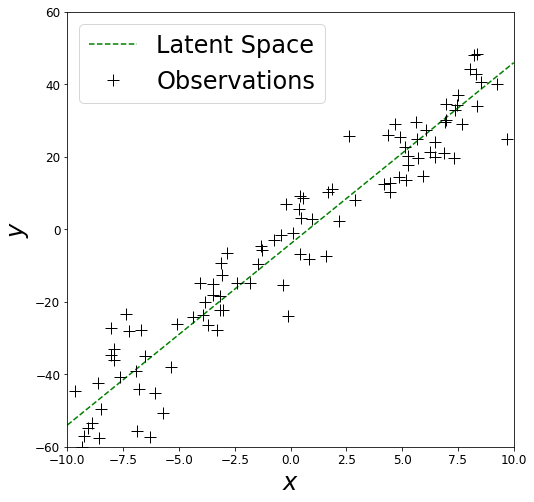

In [3]:
fig_data_with_line = plt.figure(figsize=(8, 8))

plt.plot(x, 5 * x - 4, 'g--', label='Latent Space')
plt.plot(x_data, y_data, 'k+', label='Observations', markersize=12);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.xlim(-10., 10.);
plt.ylim(-60., 60.);
plt.legend(loc='upper left');

モデル $y = wx + b + \epsilon, \; \epsilon \sim \mathcal N(\epsilon; 0, \beta^{-1})$ を作る．

In [4]:
x_data, y_data = torch.Tensor(x_data), torch.Tensor(y_data)

def model(x_data, y_data):

    w_prior = Normal(0., 10.)
    b_prior = Normal(0., 10.)
    beta = 0.1

    w = pyro.sample('weight', w_prior)
    b = pyro.sample('bias', b_prior)

    y_prior = Normal(w * x_data + b, beta ** -1)
    y = pyro.sample('obs', y_prior, obs=y_data)

    return y

モデルをデータに当てはめる．

In [5]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, 
                num_samples=2000, 
                warmup_steps=500).run(x_data, y_data)

# プロット

モデルのパラメタを事前分布からサンプリングする．

In [6]:
n_samples = 20

w_prior = Normal(0., 10.)
b_prior = Normal(0., 10.)

w_prior_sample = w_prior.sample(torch.Size([n_samples, 1])).numpy()
b_prior_sample = b_prior.sample(torch.Size([n_samples, 1])).numpy()

w_prior_cdf = w_prior.cdf(torch.linspace(-10., 10., 500)).numpy()
b_prior_cdf = b_prior.cdf(torch.linspace(-10., 10., 500)).numpy()

joint_prior_pdf = np.diff(b_prior_cdf)[:, np.newaxis] * np.diff(w_prior_cdf)

サンプリングしたパラメタから作ったモデルおよび事前分布の確率密度関数をプロットする．

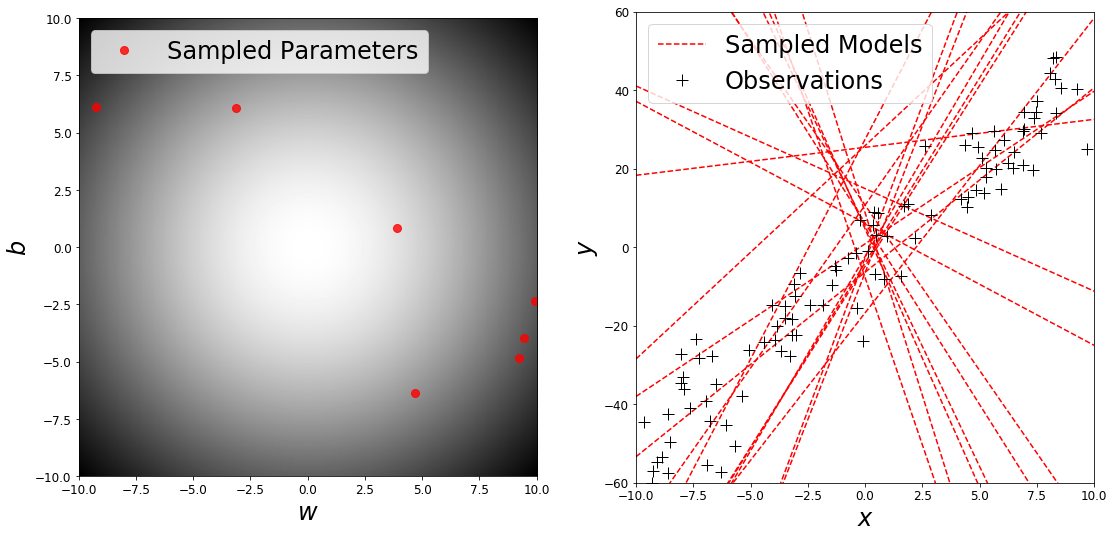

In [7]:
plt.rcParams['font.size'] = 24
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

fig_prior = plt.figure(figsize=(16, 8));

plt.subplot(121);

plt.plot(w_prior_sample, b_prior_sample, 'r.', alpha=0.8, markersize=16, label='Sampled Parameters');
plt.imshow(joint_prior_pdf, extent=[-10, 10, 10, -10], cmap='gray');
plt.gca().invert_yaxis();
plt.xlabel('$w$');
plt.ylabel('$b$');
plt.legend(loc='upper left');

plt.subplot(122);

x = np.linspace(-10., 10., 1000)

for k, (w_, b_) in enumerate(zip(w_prior_sample, b_prior_sample)):
    y = w_ * x + b_
    plt.plot(x, y, 'r--', **{'label': 'Sampled Models'} if k == 0 else {});
    
plt.plot(x_data.numpy(), y_data.numpy(), 'k+', label='Observations', markersize=12);

plt.xlabel('$x$');
plt.ylabel('$y$');
plt.xlim(-10., 10.);
plt.ylim(-60., 60.);
plt.legend(loc='upper left');

plt.tight_layout();

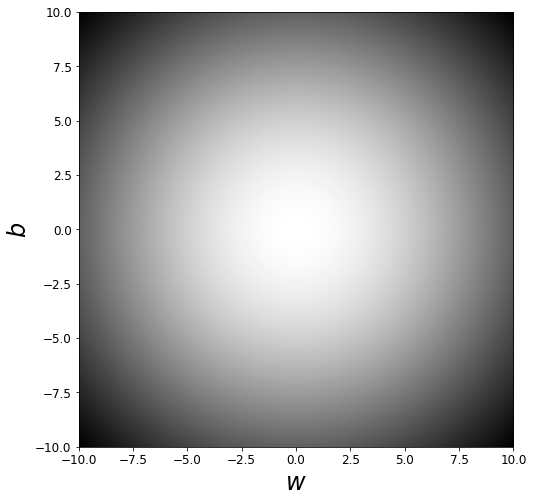

In [8]:
fig_prior_only = plt.figure(figsize=(8, 8));

plt.imshow(joint_prior_pdf, extent=[-10, 10, 10, -10], cmap='gray');
plt.gca().invert_yaxis();
plt.xlabel('$w$');
plt.ylabel('$b$');

モデルのパラメタを事後分布からサンプリングする．

In [9]:
n_samples = 20

w_posterior = EmpiricalMarginal(mcmc_run, 'weight')
b_posterior = EmpiricalMarginal(mcmc_run, 'bias')

w_posterior_sample = w_posterior.sample(torch.Size([n_samples, 1])).numpy()
b_posterior_sample = b_posterior.sample(torch.Size([n_samples, 1])).numpy()

w_posterior_cdf = Normal(w_posterior.mean, w_posterior.stddev ** 2).cdf(torch.linspace(-10., 10., 500)).numpy()
b_posterior_cdf = Normal(b_posterior.mean, b_posterior.stddev ** 2).cdf(torch.linspace(-10., 10., 500)).numpy()

joint_posterior_pdf = np.diff(b_posterior_cdf)[:, np.newaxis] * np.diff(w_posterior_cdf)

サンプリングしたパラメタから作ったモデルおよび事後分布の確率密度関数をプロットする．

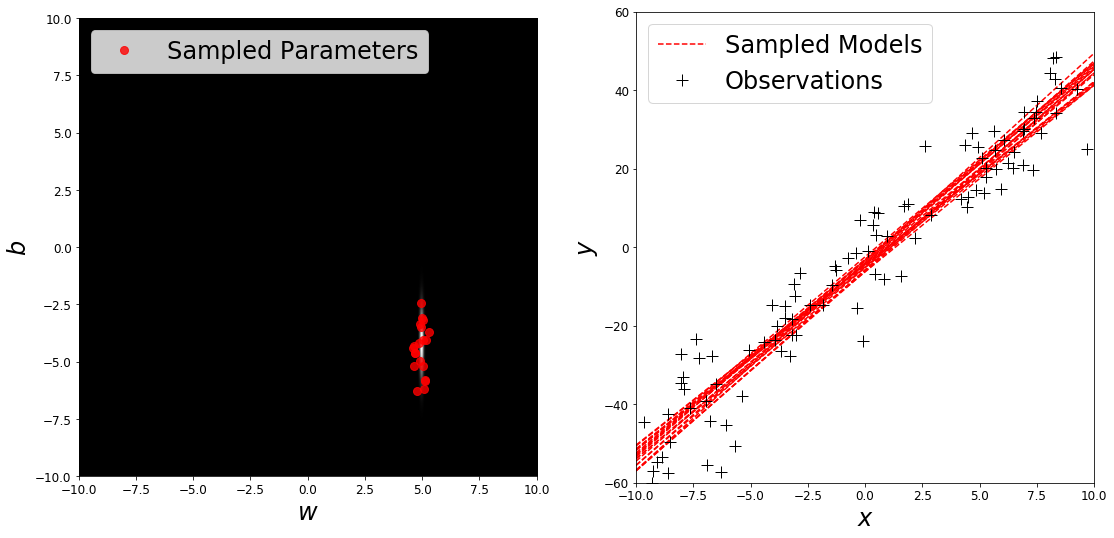

In [10]:
plt.rcParams['font.size'] = 24
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

fig_posterior = plt.figure(figsize=(16, 8));

plt.subplot(121);

plt.plot(w_posterior_sample, b_posterior_sample, 'r.', alpha=0.8, markersize=16, label='Sampled Parameters');
plt.imshow(joint_posterior_pdf, extent=[-10, 10, 10, -10], cmap='gray');
plt.gca().invert_yaxis();
plt.xlabel('$w$');
plt.ylabel('$b$');
plt.legend(loc='upper left');

plt.subplot(122);

x = np.linspace(-10., 10., 1000)

for k, (w_, b_) in enumerate(zip(w_posterior_sample, b_posterior_sample)):
    y = w_ * x + b_
    plt.plot(x, y, 'r--', **{'label': 'Sampled Models'} if k == 0 else {});

plt.plot(x_data.numpy(), y_data.numpy(), 'k+', label='Observations', markersize=12);

plt.xlabel('$x$');
plt.ylabel('$y$');
plt.xlim(-10., 10.);
plt.ylim(-60., 60.);
plt.legend(loc='upper left');

plt.tight_layout();

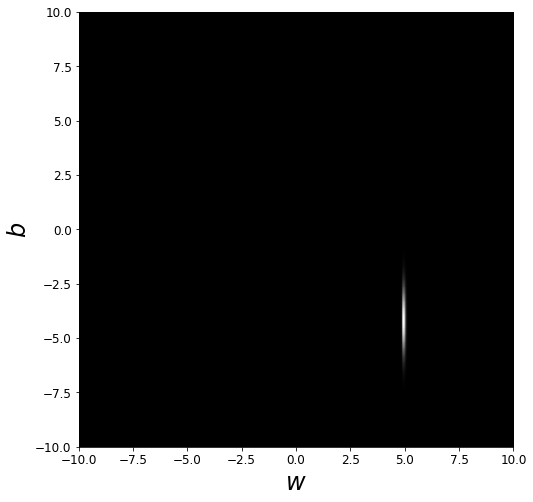

In [11]:
fig_posterior_only = plt.figure(figsize=(8, 8));

plt.imshow(joint_posterior_pdf, extent=[-10, 10, 10, -10], cmap='gray');
plt.gca().invert_yaxis();
plt.xlabel('$w$');
plt.ylabel('$b$');

In [12]:
fig_data.patch.set_alpha(0.0)
fig_data_with_line.patch.set_alpha(0.0)
fig_prior.patch.set_alpha(0.0)
fig_posterior.patch.set_alpha(0.0)
fig_prior_only.patch.set_alpha(0.0)
fig_posterior_only.patch.set_alpha(0.0)

fig_data.savefig('fig_data.pdf')
fig_data_with_line.savefig('fig_data_with_line.pdf')
fig_prior.savefig('fig_prior.pdf')
fig_posterior.savefig('fig_posterior.pdf')
fig_prior_only.savefig('fig_prior_only.pdf')
fig_posterior_only.savefig('fig_posterior_only.pdf')